## EX06

#### Импорт, чтение CSV и подключение к SQLite для чтения таблицы checker

Количество уникальных пользователей в pageviews: 13
Пользователи тестовой группы:
['user_30', 'user_14', 'user_17', 'user_10', 'user_19', 'user_21', 'user_1', 'user_18', 'user_3', 'user_25']
Количество записей о первых коммитах: 59
Средняя разница для каждого пользователя:
Количество просмотров по пользователям:
Количество коммитов по пользователям:
Итоговый датафрейм:
Размер: (11, 4)


C:\Users\stasp\AppData\Local\Temp\ipykernel_13344\472958616.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  axes[0, 0].figure.show()


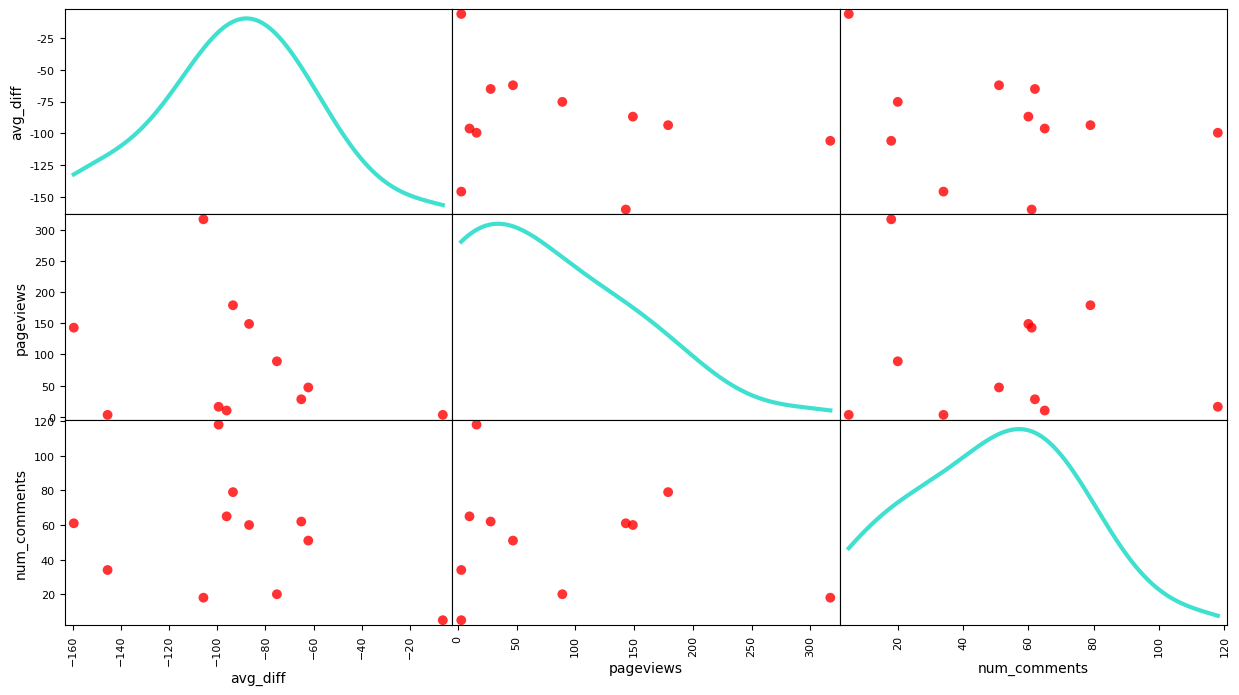

In [45]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

# Создаем соединение с базой данных
conn = sqlite3.connect('../data/checking-logs.sqlite')

# Получаем уникальных пользователей из pageviews (тестовая группа)
test_users_query = "SELECT DISTINCT uid FROM pageviews WHERE uid LIKE 'user_%'"
test_users_df = pd.io.sql.read_sql(test_users_query, conn)
test_users = test_users_df['uid'].tolist()

print(f"Количество уникальных пользователей в pageviews: {len(test_users)}")
print(f"Пользователи тестовой группы:")
print(test_users[:10])  # Показываем первых 10

# Получаем первые коммиты пользователей тестовой группы
first_commits_query = f"""
SELECT uid, labname, MIN(timestamp) as first_commit_ts
FROM checker
WHERE uid IN ({','.join(['?']*len(test_users))})
    AND numTrials = 1
    AND labname IN ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1')
GROUP BY uid, labname
"""

first_commits_df = pd.io.sql.read_sql(first_commits_query, conn, params=test_users, parse_dates=['first_commit_ts'])
print(f"Количество записей о первых коммитах: {len(first_commits_df)}")
first_commits_df.head()

# Получаем дедлайны
deadlines_df = pd.io.sql.read_sql("SELECT * FROM deadlines", conn)

# Объединяем с дедлайнами
commits_with_deadlines = first_commits_df.merge(deadlines_df[['labs', 'deadlines']], 
                                                left_on='labname', 
                                                right_on='labs')

# Исключаем project1
commits_no_project = commits_with_deadlines[commits_with_deadlines['labname'] != 'project1'].copy()

# Преобразуем deadline из unix timestamp в datetime
commits_no_project['deadline_ts'] = pd.to_datetime(commits_no_project['deadlines'], unit='s')

# Вычисляем разницу в часах
commits_no_project['diff_hours'] = (commits_no_project['first_commit_ts'] - commits_no_project['deadline_ts']).dt.total_seconds() / 3600

# Считаем среднюю разницу для каждого пользователя
avg_diff_by_user = commits_no_project.groupby('uid')['diff_hours'].mean().to_frame('average_difference')

print("Средняя разница для каждого пользователя:")
avg_diff_by_user.head()

# Подсчитываем количество просмотров для каждого пользователя
pageviews_query = "SELECT uid, COUNT(*) as number_of_pageviews FROM pageviews WHERE uid LIKE 'user_%' GROUP BY uid"
pageviews_count = pd.io.sql.read_sql(pageviews_query, conn, index_col='uid')

print("Количество просмотров по пользователям:")
pageviews_count.head()

# Подсчитываем количество коммитов (исключая project1)
commits_query = f"""
SELECT uid, COUNT(*) as number_of_commits 
FROM checker 
WHERE uid IN ({','.join(['?']*len(test_users))}) 
    AND labname != 'project1'
GROUP BY uid
"""
commits_count = pd.io.sql.read_sql(commits_query, conn, params=test_users, index_col='uid')

print("Количество коммитов по пользователям:")
commits_count.head()

# Объединяем все данные
# Берем только тех пользователей, у которых есть все три метрики
final_df = avg_diff_by_user.join(pageviews_count).join(commits_count)

# Убираем пропуски
final_df = final_df.dropna()

# Сбрасываем индекс
final_df = final_df.reset_index()

print("Итоговый датафрейм:")
print(f"Размер: {final_df.shape}")
final_df.head()

# Выбираем только числовые колонки для scatter matrix
numeric_cols = ['average_difference', 'number_of_pageviews', 'number_of_commits']

# Создаем scatter matrix
axes = scatter_matrix(
    final_df[numeric_cols],
    figsize=(15, 8),
    s=200,  # размер точек
    alpha=0.8,
    color='red',
    diagonal='kde'  # kde графики на диагонали
)

# Настройка ширины линий для kde графиков
for i, ax in enumerate(axes.flatten()):
    # Находим линии в графике и увеличиваем их толщину
    for line in ax.get_lines():
        line.set_linewidth(3)
        line.set_color('turquoise')

# Улучшаем читаемость меток
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(0)
    ax.yaxis.label.set_rotation(90)
    ax.yaxis.label.set_horizontalalignment('right')
    
# Заменяем названия осей
custom_labels = ['avg_diff', 'pageviews', 'num_comments']

for i, label in enumerate(custom_labels):
    axes[i, 0].set_ylabel(label)
    axes[-1, i].set_xlabel(label)

axes[0, 0].figure.show()

#### “Can we say that if a user has a low number of pageviews then they likely have a low number of commits?” 
### The answer: no.

#### “Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?” 
### The answer: no.

#### “Can we say that there are many users with a low number of commits and a few with a high number of commits”?
### The answer: yes.

#### “Can we say that there are many users with a small average difference and a few with a large average difference”?
### The answer: no.